In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from sodapy import Socrata


## Downloading Data from API 

Socrata is apparently the host for all of NYC's open data. I generated a key so that we wouldn't get throttled for downloading millions of entries. Basically this part just downloads all of the uber trip data during January 2020 (around 14 million records).

In [2]:
import time

def cleanup_func(trip_df):
    tdf = trip_df.copy()
    tdf.pulocationid = tdf.pulocationid.astype(int)
    tdf.dolocationid = tdf.dolocationid.astype(int)
    tdf.pickup_datetime = pd.to_datetime(tdf.pickup_datetime)
    tdf.dropoff_datetime = pd.to_datetime(tdf.dropoff_datetime)
    return tdf

In [65]:
with Socrata('data.cityofnewyork.us', 'vA3MfkSw5kKhpzNkitJkv5yFP') as client:    
    
    queried_results = list(client.get_all("2v9c-2k7f"))
    base_nums = pd.DataFrame.from_records(queried_results, coerce_float = True)

In [90]:
base_nums = base_nums.astype({'year':int,'month':int,'total_dispatched_trips':int,'total_dispatched_shared_trips':int,'unique_dispatched_vehicles':int})
base_nums_jan2020 = base_nums[(base_nums.year == 2020) & (base_nums.month == 1)]
base_nums_jan2020.head(3)

,base_license_number,base_name,year,month,month_name,total_dispatched_trips,total_dispatched_shared_trips,unique_dispatched_vehicles,dba
40,B02951,"APPROACH QUALITY TRANSPORTATION, LLC",2020,1,January,149,0,2,NaN
89,B00256,FAST OPERATING CORP,2020,1,January,35041,0,540,CARMEL C/L SVCE
175,B02379,THE OPTION TRANSPORTATION CORP.,2020,1,January,2467,0,23,NaN


In [2]:
#dont run this cell if data is already  in folder
tic = time.time()
with Socrata('data.cityofnewyork.us', 'vA3MfkSw5kKhpzNkitJkv5yFP') as client:
    #gets the taxi zones (the geometry of each zone in the city + the zone name and borough)
    taxi_zones =  pd.DataFrame.from_records(client.get_all('755u-8jsi'))
    
    #run through all the uber results in jan 2020/feb 2020 (pre-pandemic and there's no data in 2021)
    high_volume_query = client.get('yrt9-58g8',
                                   limit = 20000000,
                                   where = 'hvfhs_license_num = "HV0003" and pickup_datetime < "2020-02-01" and pickup_datetime > "2020-01-01"')
    
    trips = cleanup_func(pd.DataFrame.from_records(high_volume_query))
print(time.time() - tic)

1268.1834218502045


In [3]:
#run this cell instead if the data is already in folder

with Socrata('data.cityofnewyork.us', 'vA3MfkSw5kKhpzNkitJkv5yFP') as client:
    #gets the taxi zones (the geometry of each zone in the city + the zone name and borough)
    taxi_zones =  pd.DataFrame.from_records(client.get_all('755u-8jsi'))
    
trips = cleanup_func(pd.read_csv('january-2020-uber-data.csv', index_col = 0))

/usr/local/lib/python3.9/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


There appears to be 262 distinct zones recorded, and there are some zones in the trips dataset not in here, so remove those trips from  trips.

In [4]:
trips = trips[(trips.pulocationid.isin(taxi_zones.location_id.astype(int))) & (trips.dolocationid.isin(taxi_zones.location_id.astype(int)))]

## Minimum Drivers Active At Once (# of concurrent trips)

In [39]:
from tqdm.notebook import tqdm

intervals = trips[['pickup_datetime','dropoff_datetime']].values
intervals = intervals.astype('datetime64[s]').astype(int)

#builds a table of TIME - TYPE where type refers to the start/end of an interval
times = np.r_[np.c_[intervals[:,0], np.zeros(intervals.shape[0])],np.c_[intervals[:,1], np.ones(intervals.shape[0])]]
times = times[times[:,0].argsort()]

In [40]:
#iteratively go through where first column is the time, second column is the # of concurrent drivers
concurrent_drivers = []
num_drivers = 0

for time in tqdm(times, position = 0, leave = True):
    if time[1] == 0:
        num_drivers += 1
    elif time[1] == 1:
        num_drivers -= 1
    concurrent_drivers.append((time[0],num_drivers))

  0%|          | 0/28308262 [00:00<?, ?it/s]

In [71]:
dc = pd.DataFrame(concurrent_drivers[::100], columns = ['Time', 'Driver Count'])
dc.Time = dc.Time.astype('datetime64[s]')
dc['Hour'] = dc.Time.dt.hour
dc

,Time,Driver Count,Hour
0,2020-01-01 00:00:01,1,0
1,2020-01-01 00:00:32,101,0
2,2020-01-01 00:01:04,201,0
3,2020-01-01 00:01:41,301,0
4,2020-01-01 00:02:13,399,0
...,...,...,...
283078,2020-02-01 00:27:25,461,0
283079,2020-02-01 00:29:25,361,0
283080,2020-02-01 00:31:51,261,0
283081,2020-02-01 00:35:22,161,0


Text(0.5, 1.0, 'Number of Active Uber Trips')

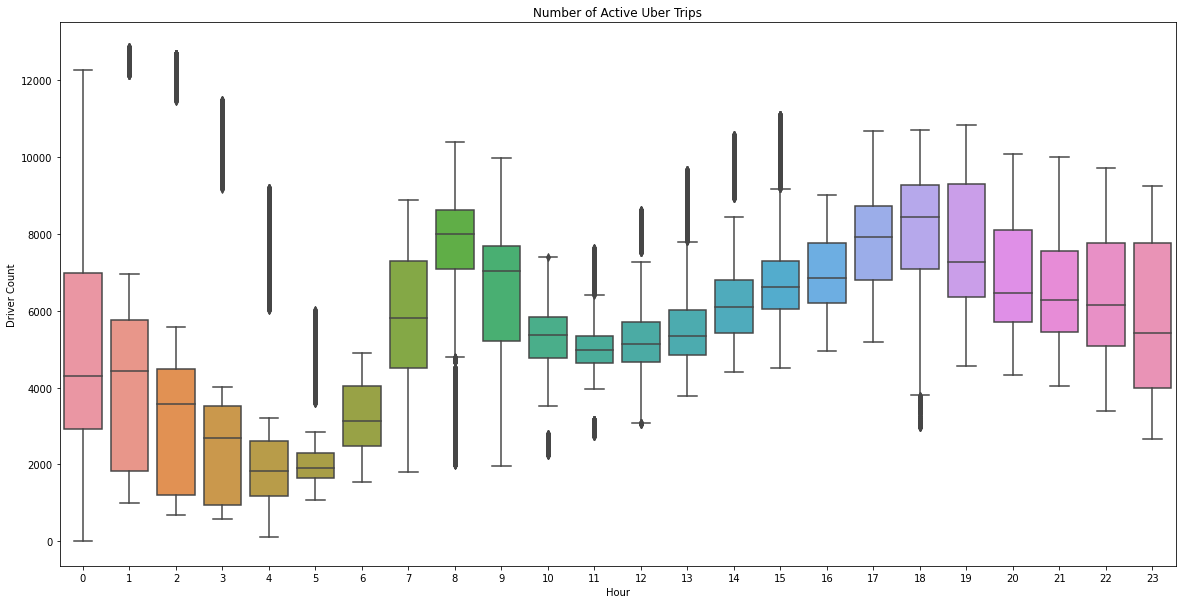

In [74]:
#plot
plt.figure(figsize=(20,10))
sns.boxplot(x = 'Hour', y = 'Driver Count', data = dc)

plt.title('Number of Active Uber Trips')


## Some Visual Examination of Time-Varying Pickups/Service Times

In [96]:
#first examine distribution differences of trips per day/week across January
#then examine distribution differences within each day
#examine distributions of pickups across zones
#14 million trips in january 2020

trips['dayofweek'] = trips.pickup_datetime.dt.dayofweek
trips['day'] = trips.pickup_datetime.dt.day
day_groups = trips.groupby('day')
trips_by_day = day_groups['hvfhs_license_num'].count()

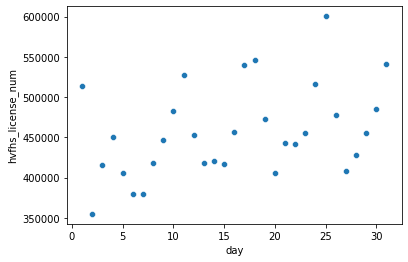

In [97]:
_ = sns.scatterplot(data = trips_by_day)
#definitely a little seasonality

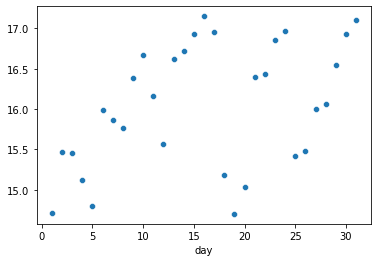

In [99]:
avg_trip_length = day_groups.apply(lambda group: (group.dropoff_datetime - group.pickup_datetime).mean().seconds / 60)
_ = sns.scatterplot(data = avg_trip_length)

In [100]:
trips[['hvfhs_license_num','dispatching_base_num','pickup_datetime','dropoff_datetime','pulocationid','dolocationid']].to_csv('january-2020-uber-data.csv')

In [102]:
#group by hour
trips['hour'] = trips.pickup_datetime.dt.hour
hour_groups = trips.groupby('hour')
trips_by_hour = hour_groups['hvfhs_license_num'].count()

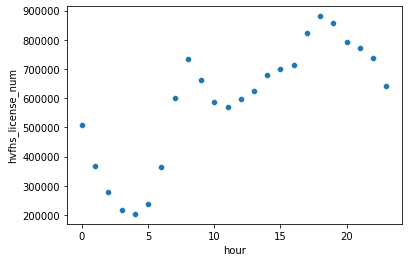

In [103]:
_ = sns.scatterplot(data = trips_by_hour)

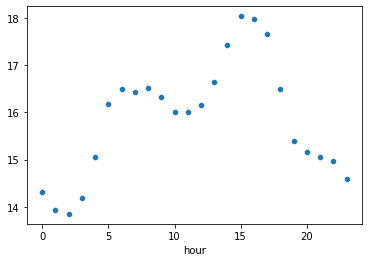

In [104]:
#average trip length by hour
avg_trip_length_hourly = hour_groups.apply(lambda group: 
                                           (group.dropoff_datetime - group.pickup_datetime).mean().seconds / 60)
_ = sns.scatterplot(data = avg_trip_length_hourly)

## Extracting Distributions

In [105]:
#eventually need to discover these things:
#time varying rate of arrivals over time by the hour for a whole month
#time varying rate of arrivals for each zone
#the distribution of dropoff zones for each pickup zone (where the customer is going)
#distribution of service times for each pickup - dropoff zone

#group by zones
zone_groups = trips.groupby('pulocationid')

In [106]:
#check the zone -> zone distribution
zone_to_zone = pd.crosstab(index = trips.pulocationid, columns = trips.dolocationid)

The below graph shows the number of pickups in each zone (265 total) in January 2020. Very long-tailed, a few high-frequency areas. We could maybe group together zones to reduce computation times but that would require some more analysis/clustering so it might be best to just stick with the 265 zones for simpler system logic.

<AxesSubplot:xlabel='pulocationid'>

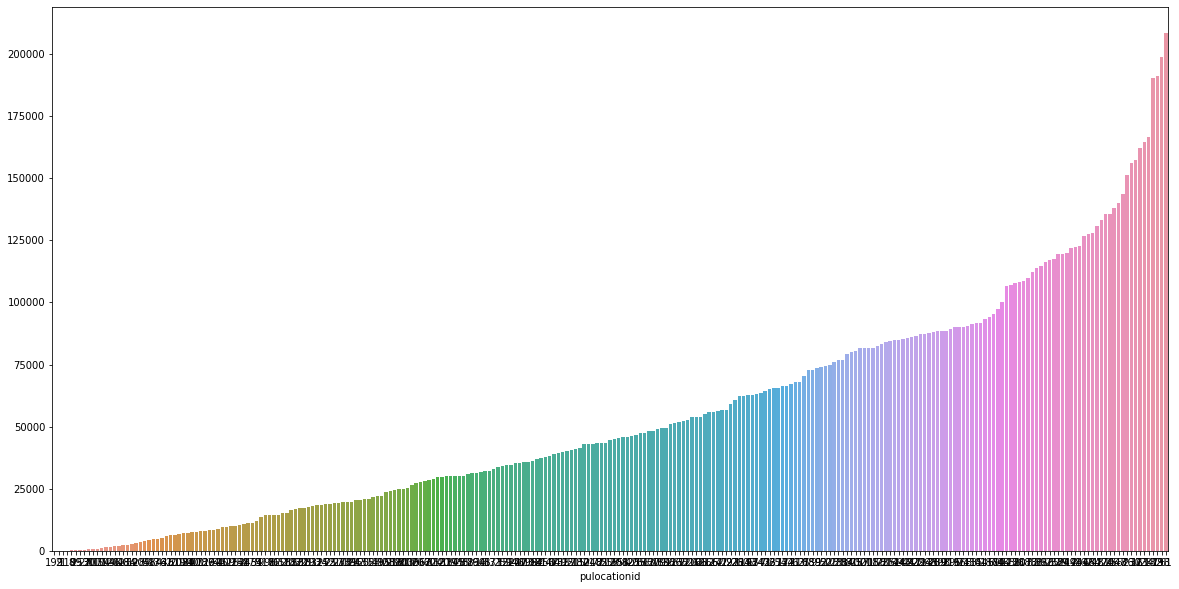

In [107]:
pickups = zone_to_zone.sum(axis=1).sort_values()
#total pickups for each zone, pretty long tailed
plt.figure(figsize=(20,10))
sns.barplot(x = pickups.index.astype(str), y = pickups.values)

In [108]:
#take an example zone, how to create a distribution for its customer arrivals?
#first visualize a few examples

def visualize_zone_pickups_over_month(zone_id):
    zone_trips_ex = zone_groups.get_group(zone_id).copy()
    
    #grouping by hour starting from the first of each month
    zone_trips_ex['hour_of_month'] = zone_trips_ex.hour + 24 * (zone_trips_ex.day - 1)
    arrivals_by_hour_ex = zone_trips_ex.groupby('hour_of_month')['hvfhs_license_num'].count()

    #graphing arrivals per hour over time
    plt.figure(figsize=(20,10))
    sns.lineplot(x = arrivals_by_hour_ex.index, y = arrivals_by_hour_ex.values)

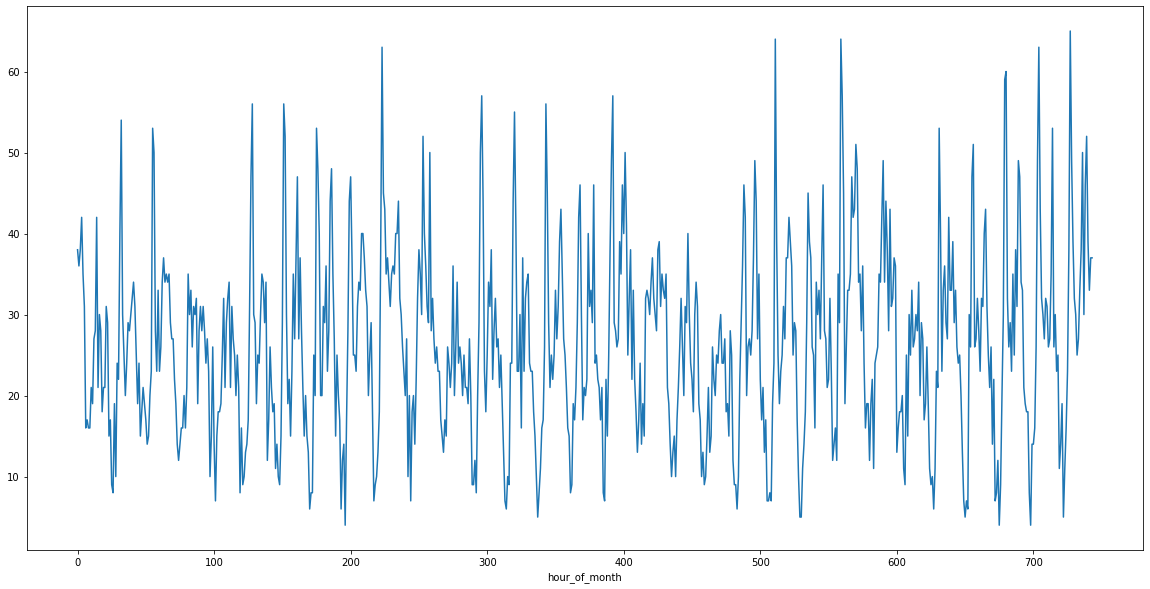

In [109]:
visualize_zone_pickups_over_month(139)

In [110]:
#based on a few examples from above it looks like there isn't too much variation from week to week
#definitely variation within a week/day
#to simplify the problem just fit a rate function to the daily variation for now
def visualize_daily_zone_pickups(zone_id):
    zone_trips_ex = zone_groups.get_group(zone_id).copy()
    
    #divide by 31 days in january
    arrivals_by_hour_ex = zone_trips_ex.groupby('hour')['hvfhs_license_num'].count() / 31

    #graphing arrivals per hour over a day
    plt.figure(figsize=(20,10))
    sns.scatterplot(x = arrivals_by_hour_ex.index, y = arrivals_by_hour_ex.values)

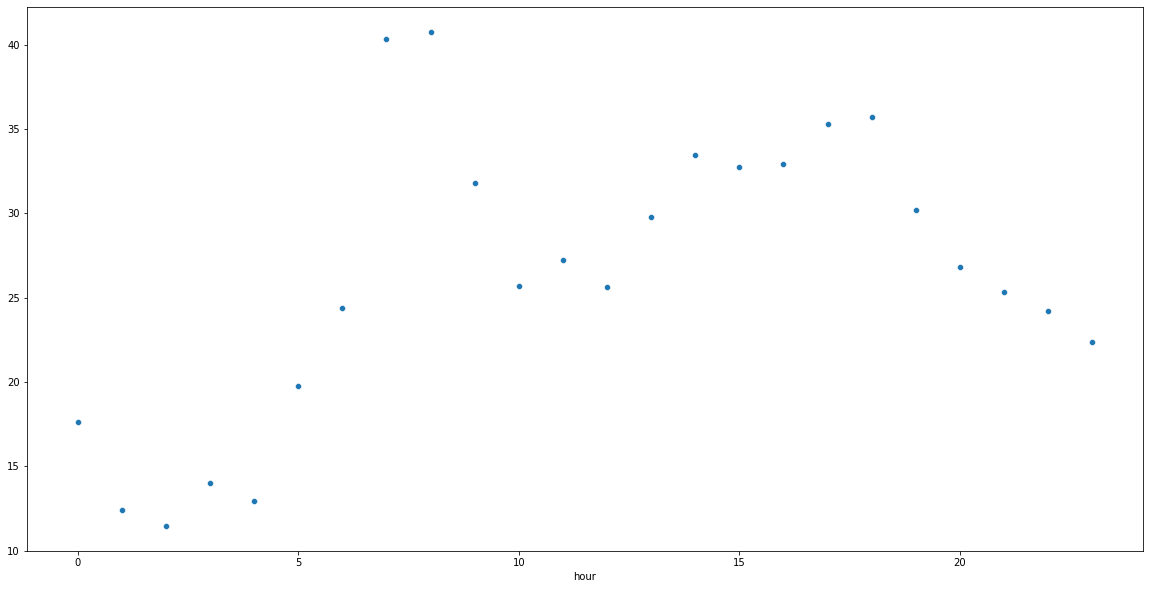

In [111]:
visualize_daily_zone_pickups(139)

In [112]:
def visualize_daily_zone_pickups(zone_id):
    zone_trips_ex = zone_groups.get_group(zone_id).copy()
    
    #divide by 31 days in january
    arrivals_by_hour_ex = zone_trips_ex.groupby('hour')['hvfhs_license_num'].count() / 31

    #graphing arrivals per hour over a day
    plt.figure(figsize=(20,10))
    sns.scatterplot(x = arrivals_by_hour_ex.index, y = arrivals_by_hour_ex.values)

In [113]:
def extract_zone_daily_information(zone_group):
    #arrival information: array(24)
    arr_by_hour = pd.Series(index = np.arange(0,24), data = np.zeros(24))
    arr_by_hour += zone_group.groupby('hour')['hvfhs_license_num'].count() / 31
    arr_by_hour = arr_by_hour.fillna(0)
    
    #distribution of dropoffs: array(264)
    dist_dropoffs = pd.Series(index = np.arange(1,264), data = np.zeros(263))
    dist_dropoffs += zone_group.groupby('dolocationid')['hvfhs_license_num'].count()
    dist_dropoffs = dist_dropoffs.fillna(0)
    
    return arr_by_hour, dist_dropoffs

extract_zone_daily_information(zone_groups.get_group(139))

(0     17.645161
 1     12.387097
 2     11.451613
 3     14.032258
 4     12.935484
 5     19.741935
 6     24.387097
 7     40.354839
 8     40.774194
 9     31.806452
 10    25.709677
 11    27.258065
 12    25.645161
 13    29.774194
 14    33.451613
 15    32.741935
 16    32.935484
 17    35.322581
 18    35.741935
 19    30.193548
 20    26.806452
 21    25.354839
 22    24.225806
 23    22.354839
 dtype: float64,
 1      4.0
 2      0.0
 3      0.0
 4      1.0
 5      0.0
       ... 
 259    3.0
 260    9.0
 261    1.0
 262    0.0
 263    7.0
 Length: 263, dtype: float64)

In [114]:
from pandarallel import pandarallel

# Initialization
pandarallel.initialize(progress_bar = True)

extracted_information = zone_groups.parallel_apply(extract_zone_daily_information)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [115]:
extracted_information.to_pickle('arrival_and_dropoff_distributions')

0it [00:00, ?it/s]

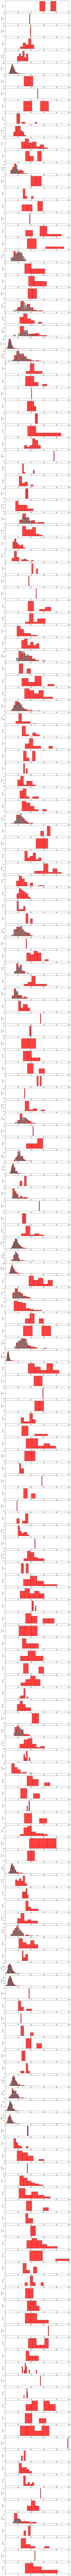

In [220]:
import scipy.stats as stats

def reject_outliers(data, m = 2.5):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

#what do the service time distributions look like
def visualize_service_time_zone(zone_group):
    do_groups = zone_group.groupby('dolocationid')
    f, ax = plt.subplots(len(do_groups),1,figsize=(10,2*len(do_groups)))
    for g, a in tqdm(zip(do_groups, ax), position = 0, leave = True):
        g = g[1]
        service_times = g.dropoff_datetime - g.pickup_datetime
        service_times = service_times.dt.seconds / 60
        sns.histplot(x = service_times, color = 'red', ax = a)
        a.set_xlim(0,100)
        
        if g.shape[0] > 50:
            outlier_adjusted = reject_outliers(service_times)
            gammas = np.random.normal(loc = outlier_adjusted.mean(), scale = outlier_adjusted.std(), size = service_times.shape[0])
            #stats.gamma.rvs(service_times, size = service_times.shape[0])
            sns.histplot(x = gammas, color = 'gray', ax = a)

visualize_service_time_zone(zone_groups.get_group(160))

In [249]:
#extracting gamma variables
def extract_trip_time_means(zone_group):
    
    def fit_norm_and_minmax(arr):
        if len(arr) > 50:
            oarr = reject_outliers(arr)
        else:
            oarr = arr
        return pd.Series([oarr.mean(), oarr.std(), arr.min(), arr.max(), arr.shape[0]], index = ['mean','std','min','max','count'])
    
    def get_group_norm_and_minmax(group):
        services = (group.dropoff_datetime - group.pickup_datetime).dt.seconds / 60
        return fit_norm_and_minmax(services)
    
    #this is to make sure the output of each zone group is consistent, since some pickup zones don't have any dropoffs in some zones
    service_times = pd.DataFrame(data = np.zeros((263,5)), index = np.arange(1,264), columns = ['mean','std','min','max','count'])
    service_times += zone_group.groupby('dolocationid').apply(get_group_norm_and_minmax)
    
    return service_times

extract_trip_time_means(zone_groups.get_group(139))

,mean,std,min,max,count
1,64.916667,12.526749,53.550000,79.350000,4.0
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,38.000000,NaN,38.000000,38.000000,1.0
5,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
259,35.261111,5.827672,28.566667,39.200000,3.0
260,34.557407,13.935100,24.416667,68.683333,9.0
261,46.116667,NaN,46.116667,46.116667,1.0
262,NaN,NaN,NaN,NaN,NaN


In [311]:
#NaN values just means there's no data on zone -> zone trips
#all of these are means that can be used to sample from exponential distributions

trip_times = zone_groups.parallel_apply(extract_trip_time_means)

In [312]:
#missing indices, add them in manually (there's no pickups here)
missing = np.arange(1,263)[~np.isin(np.arange(1,263),np.unique([i[0] for i in trip_times.index]))]

to_append = []
for m in missing:
    to_append.append(pd.DataFrame(np.zeros((263,5)), 
                                  index = pd.MultiIndex.from_tuples([(m,i) for i in range(1,264)]),
                                  columns = ['mean','std','max','min','count']))
to_append = pd.concat(to_append)
trip_times_filled = trip_times.append(to_append).fillna(0)

In [320]:
#fill in the empty ones with symmetric logic (2->124 = 124->2)
for i in tqdm(trip_times_filled.index, position = 0, leave = True):
    if (trip_times_filled.loc[i] == 0).all():
        inv_index = (i[1],i[0])
        if ~(trip_times_filled.loc[inv_index] == 0).all():
            trip_times_filled.loc[i] += trip_times_filled.loc[inv_index]

  0%|          | 0/69169 [00:00<?, ?it/s]

In [327]:
trip_times_filled.to_parquet('trip_time_means')